# New York City Taxi Trip Duration

Соревнование на Kaggle - https://www.kaggle.com/c/nyc-taxi-trip-duration/overview. Нужно предсказать продолжительность поездки такси по следующим признакам: 
* id - идентификатор поездки
* vendor_id - код провайдера, от которого пришла информация о поездке
* pickup_datetime - время старта поездки
* dropoff_datetime - время окончания поездки
* passenger_count - число пассажиров (вводится водителем)
* pickup_longitude - долгота точки посадки
* pickup_latitude - широта точки посадки
* dropoff_longitude - долгота точки высадки
* dropoff_latitude - долгота точки высадки
* store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
* trip_duration - продолжительность поездки в секундах

## Оглавление:
*  Разведовочный анализ
    * Подготовка данных
    * Целевая переменная и координаты
    * Работа с переменной расстояния
    * Работа с pickup_datetime переменной   
* Обучение на необработанных данных и константные предположения
* Обучение на новых признаках
    * Функции предобработки и выделения признаков
    * Обучение на новых признаках с выбросами
    * Удаление выбросов
    * Обучение на данных без выбросов и с новыми признаками
    * Подбор гиперпараметров
    * Random Forest

## Разведовочный анализ

### Подготовка данных

Подключаем все необходимые библиотеки

In [883]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import calendar

In [884]:
sns.set(style="darkgrid")

Загружаем и просматриваем тренировочные и тестовые данные

In [885]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [886]:
data.sample(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
286073,id2508567,2,2016-04-21 15:04:18,2016-04-21 15:13:39,1,-73.973770,40.758591,-73.961601,40.756626,N,561
1010715,id0791919,2,2016-04-05 21:46:58,2016-04-05 22:21:30,1,-73.976768,40.759167,-73.959755,40.661797,N,2072
1375776,id1486270,2,2016-01-18 10:38:06,2016-01-18 10:47:29,2,-73.990097,40.733639,-74.008904,40.713097,N,563


In [887]:
data_test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


Замечаем, что колонка dropoff_datetime отсутствует в тестовой выборке, значит в будущем нам следует ее удалить. 

In [888]:
print("Training shape - {}".format(data.shape))
print("Testing shape - {}".format(data_test.shape))

Training shape - (1458644, 11)
Testing shape - (625134, 9)


Пропущенных значений в данных нет

In [889]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Все индификаторы поездок уникальны

In [890]:
print("Id is unique") if data['id'].nunique() == data.shape[0] else print("Id is not unique")

Id is unique


In [891]:
data['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [892]:
data['vendor_id'].unique()

array([2, 1], dtype=int64)

In [893]:
data['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

In [894]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Столбцы с датами были отнесены к типу object. Для удобства будет лучше преобразовать их в тип datetime:

In [895]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

Временной промежуток данных:

In [896]:
print(data['pickup_datetime'].min())
print(data['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


### Целевая переменная и координаты

Посмотрим теперь на целевую переменную, а именно на колонку trip_duration, построим ее распределение. 

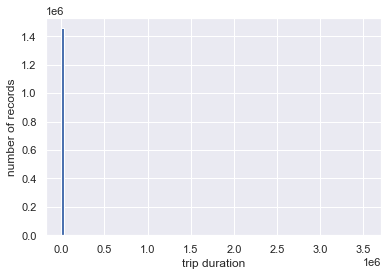

In [897]:
plt.hist(data['trip_duration'].values, bins = 100)
plt.xlabel("trip duration")
plt.ylabel("number of records")
plt.show()

Получилось не очень информативно, поробуем логарифмировать целевую пременную и вновь построить распределение. Используем для этого np.log1p логарифмирующий следующим образом: log(1 + x)

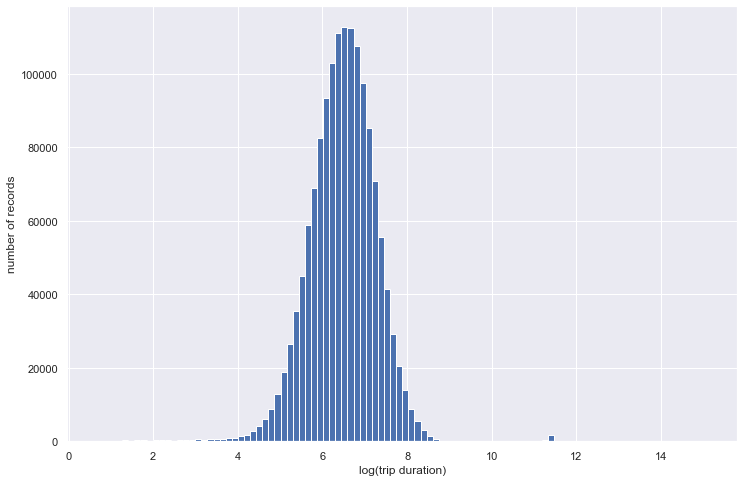

In [898]:
data['log_trip_duration'] = np.log1p(data['trip_duration'].values)
plt.figure(figsize = (12,8))
plt.hist(data['log_trip_duration'].values, bins = 100)
plt.xlabel("log(trip duration)")
plt.ylabel("number of records")
plt.show()

В основном, длительность всех поездок варьируется в следующих пределах:

In [899]:
print("from {} to {} in seconds".format(np.exp(4.5), np.exp(9)))
print("from {} to {} in minutes".format(np.exp(4.5) // 60, np.exp(9) // 60))

from 90.01713130052181 to 8103.083927575384 in seconds
from 1.0 to 135.0 in minutes


На верхнем графике между значениями 10 и 12 на оси абсцисс видно, что есть отдельный блок заказов с нетипично большой длительностью нужно присмотреться к нему повниметельнее. 

In [900]:
lower_border = np.exp(10) // 3600
print("10 on log(trip_duration) is",(np.exp(10) -1) // 3600, "hours")

10 on log(trip_duration) is 6.0 hours


In [901]:
print("11 on log(trip_duration) is",(np.exp(11)-1) // 3600, "hours")

11 on log(trip_duration) is 16.0 hours


In [902]:
data['trip_duration'].max() // 3600

979

Поездка длительностью 979 часов точно является выбросом. Посмотрим сколько всего таких выбросов присутствует в нашей выборке.

In [903]:
data['trip_duration_in_hours'] = data['trip_duration'] // 3600
big_duration = data[data['trip_duration_in_hours'] >= 6]['trip_duration_in_hours']
print("number of trips that are longer than 6 hours = ", big_duration.count())

number of trips that are longer than 6 hours =  2061


In [904]:
big_duration.unique()

array([ 23,  22,  10,  11,  13,  12,  17,  14,   6,  18,  21,  16,   7,
         8,  20,  15, 538,  19,   9, 569, 618, 979], dtype=int64)

Поездки длительностью 538, 569, 618 часов тоже записываем как выбросы

In [905]:
for i in [6,9,10,15,20,24, 538, 569, 618, 979]:
    n = data[data['trip_duration_in_hours'] >= i]['trip_duration_in_hours'].count()
    print("Number of trips durations >= {0} hours is {1}".format(i, n))

Number of trips durations >= 6 hours is 2061
Number of trips durations >= 9 hours is 2020
Number of trips durations >= 10 hours is 2012
Number of trips durations >= 15 hours is 1973
Number of trips durations >= 20 hours is 1933
Number of trips durations >= 24 hours is 4
Number of trips durations >= 538 hours is 4
Number of trips durations >= 569 hours is 3
Number of trips durations >= 618 hours is 2
Number of trips durations >= 979 hours is 1


Видно, что выбрасов не так уж и много, однако поездок находящихся в дапозоне от 6 до 24 часов значительное количество и определенно нужно выяснить что это такое. Логично предположить, что нетипичная продолжительность поездок связана с большим пройденным расстоянием. Посмотрим на карте где эти поездки начинались и где заканчивались, таким образом, проследим маршруты такси, плюс ко всему исследуем координаты на различные аномалии. Функция ниже рисует точки на карте по их координатам

In [906]:
def draw_circles_on_map(data, latitude_column, longitude_column, color):

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

df - датафрем только с поездками длительность от 6 до 24 часов. Считаем до 24 часов, так как поездки длительнее 24 часов точно являются выбросами, это видно в последнем цикле с подсчетом поездок

In [907]:
df = data[(data['trip_duration_in_hours'] > 6) & (data['trip_duration_in_hours'] < 24)]

In [908]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 531 to 1458076
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      2046 non-null   object        
 1   vendor_id               2046 non-null   int64         
 2   pickup_datetime         2046 non-null   datetime64[ns]
 3   dropoff_datetime        2046 non-null   datetime64[ns]
 4   passenger_count         2046 non-null   int64         
 5   pickup_longitude        2046 non-null   float64       
 6   pickup_latitude         2046 non-null   float64       
 7   dropoff_longitude       2046 non-null   float64       
 8   dropoff_latitude        2046 non-null   float64       
 9   store_and_fwd_flag      2046 non-null   object        
 10  trip_duration           2046 non-null   int64         
 11  log_trip_duration       2046 non-null   float64       
 12  trip_duration_in_hours  2046 non-null   int

На карте показаны начальные координаты случайно выбранных поездок. N - количество случайно выбранных поездок из df, определенного выше

In [909]:
N = 500
df_1 = df.sample(N)
draw_circles_on_map(df_1, "pickup_latitude", "pickup_longitude", "blue")

Конечные координаты N случайно выбранных поездок

In [910]:
draw_circles_on_map(df_1, "dropoff_latitude", "dropoff_longitude", "red")

Все поездки начинаются и заканчиваются в городе Нью-Йорк или его окрестностях, не складывается впечатление, что аномальная длительность связана с длиной поездки. Впоследствии введем признак расстояния, чтобы посмотреть его влияние на длительность. Попробуем сразу построить начальные координаты всех поездок, чтобы найти что-нибудь необычное.

In [911]:
draw_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

### Работа с переменной расстояния 

Наиболее сильно переменная продолжительности поездки должна зависеть расстояния. Введем признак расстояния по принципу подсчета расстояния на сфере (Haversine formula). Также на всяки случай введем манхетанское расстояние. 

In [912]:
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [913]:
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [914]:
data['distance_haversine'] = haversine_distance(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)
data['distance_manhattan'] = manhattan_distance(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)

Логарифмируем расстояние

In [915]:
data['log_distance_haversine'] = data['distance_haversine'].apply(lambda x: np.log1p(x))

Посмотрим на корреляцию между различными расстояниями и логарифмированной целевой переменной

In [916]:
for i in ['log_distance_haversine', 'distance_haversine', 'distance_manhattan']:
    print(data[[i]].corrwith(data['log_trip_duration']))

log_distance_haversine    0.749882
dtype: float64
distance_haversine    0.573595
dtype: float64
distance_manhattan    0.564337
dtype: float64


Сделаем тоже самое только теперь с обычной целевой переменной

In [917]:
for i in ['log_distance_haversine', 'distance_haversine', 'distance_manhattan']:
    print(data[[i]].corrwith(data['trip_duration']))

log_distance_haversine    0.102519
dtype: float64
distance_haversine    0.094777
dtype: float64
distance_manhattan    0.094225
dtype: float64


Отметим, что в последнем случае признаки гораздо меньше коррелируются с таргетом. Построим график, чтобы узнать зависимость между расстоянием и длительностью поездки.

Text(0.5, 0, 'distance_haversine')

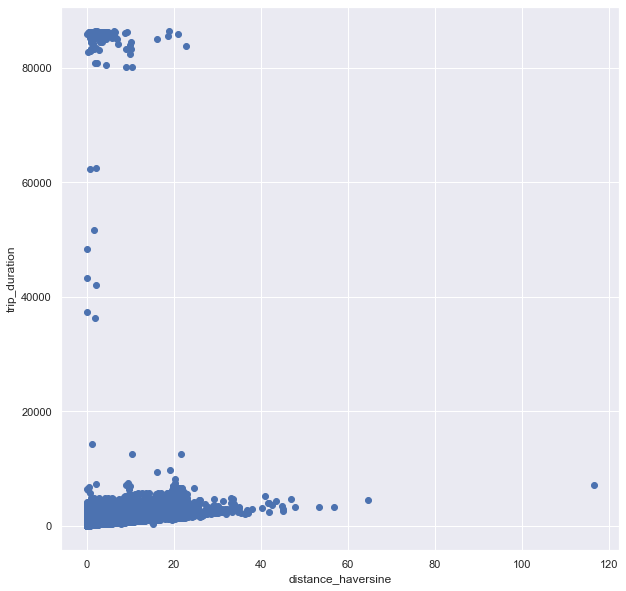

In [918]:
plt.figure(figsize=(10,10))
plt.scatter(data['distance_haversine'][:100000], data['trip_duration'][:100000])
plt.ylabel('trip_duration')
plt.xlabel('distance_haversine')

В нижней части точки выстраиваются в линию, наиболее вероятно, что поездки с длительностью > 6*3600 = 21600 (верхняя часть графика) можно считать выбросами для модели. Это как раз те поездки с длительностью более 6 часов.

Построим распределение логарифмированного расстояния Хаверсина, распределение обычного расстояния опять не информативно.  

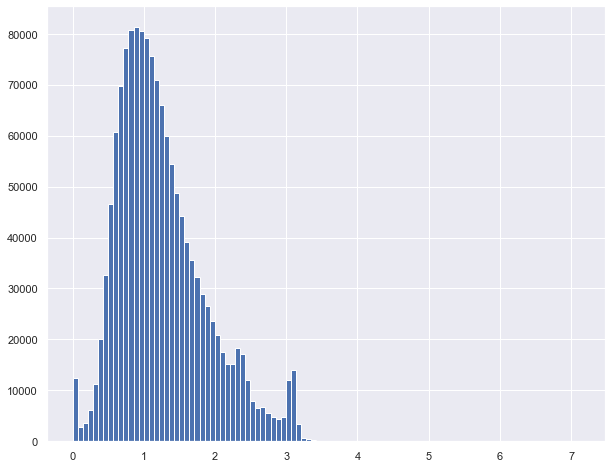

In [919]:
plt.figure(figsize=(10,8))
plt.hist(data['log_distance_haversine'], bins = 100)
plt.show()

В целом все выглядит довольно хорошо. Посмотрим на участок, где расстояние больше значения 4

In [920]:
np.exp(1.5)-1

3.4816890703380645

In [921]:
x = data[data['log_distance_haversine'] > 3.5]['log_distance_haversine']
y = data[data['log_distance_haversine'] > 3.5]['log_trip_duration']

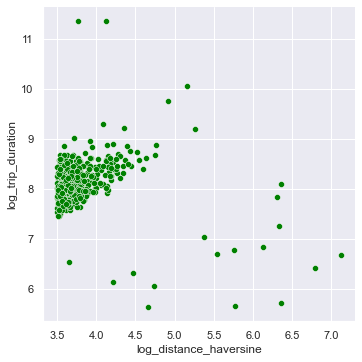

In [922]:
sns.relplot(x = x, y = y, color = 'green')

In [923]:
print("distance in km = {1} for {0} minutes ".format((np.exp(8)-1)/60 , np.exp(3.5) - 1))

distance in km = 32.11545195869231 for 49.66596645069547 minutes 


In [924]:
(np.exp(7.5)-1) / 60 

30.11737357426772

In [925]:
 np.exp(5) - 1 

147.4131591025766

В основном точки распределены логично удалим те точки, где log_distance_haversine > 5 (147 км) и log_trip_duration < 7.5 (30 минут)

### Работа с pickup_datetime переменной

Добавим следующие признаки в датасет
* pickup_date - дата без времени
* pickup_day - число месяца
* pickup_day_of_the_week - день недели
* pickup_month - месяц
* pickup_hour - час начала поездки

In [926]:
data['pickup_date'] = data['pickup_datetime'].dt.date
data['pickup_day'] = data['pickup_datetime'].apply(lambda x: x.day)
data['pickup_day_of_the_week'] = data['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
data['pickup_month'] = data['pickup_datetime'].apply(lambda x: x.month)
data['pickup_hour'] = data['pickup_datetime'].apply(lambda x: x.hour)

Посмотрим на количество поездок в различные дни месяца 

<AxesSubplot:xlabel='pickup_day', ylabel='count'>

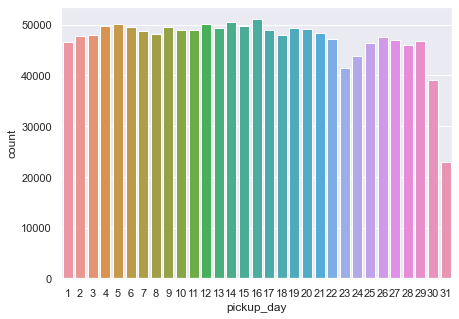

In [368]:
plt.figure(figsize = (7,5))
sns.countplot(x = 'pickup_day', data = data)

Рассмотрим теперь количество поедок на всем временном интервале представленном в датасете

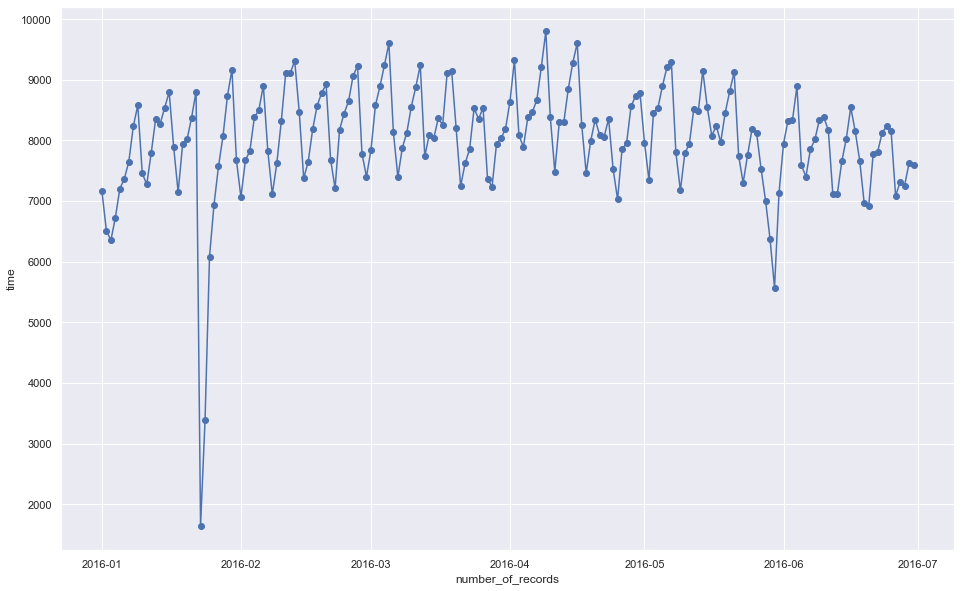

In [357]:
plt.figure(figsize = (16,10))
plt.plot(data.groupby('pickup_date').count()[['id']], 'o-')
plt.xlabel('number_of_records')
plt.ylabel('time')
plt.show()

На графике видно что есть период с слишком маленьким количеством заказов. Вычислим время, когда это случилось и посмотрим, что могло повлиять на такой итог 

In [358]:
tmp = data.groupby('pickup_date').count()[['id']].reset_index()

In [364]:
tmp.sort_values(by = ['id'], ascending = True)[:10]

,pickup_date,id
22,2016-01-23,1648
23,2016-01-24,3383
150,2016-05-30,5570
24,2016-01-25,6084
2,2016-01-03,6353
149,2016-05-29,6372
1,2016-01-02,6512
3,2016-01-04,6725
171,2016-06-20,6910
25,2016-01-26,6941


Самое низкое количество заказов пришлось на 23 и 24 января 2016 года. Как раз именно эти дни выделяются на графике сверху. В период с 23 по 24 по данным Википедии был введен запрет на передвижение по городу из-за мощнейшей снежной бури - https://en.wikipedia.org/wiki/January_2016_United_States_blizzard 

Количество поездок по дням недели

<AxesSubplot:xlabel='pickup_day_of_the_week', ylabel='count'>

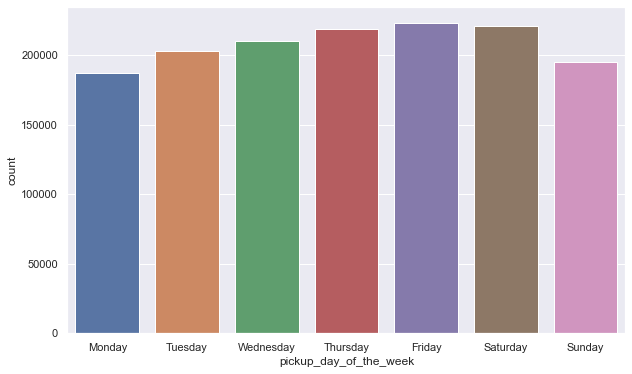

In [411]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'pickup_day_of_the_week', data = data, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Средняя длина поездки по дням недели

In [390]:
avg_trip_duration = data.groupby(['pickup_day_of_the_week'])['trip_duration'].mean().reset_index()

In [396]:
avg_trip_duration.rename(columns = {'trip_duration' : 'avg_trip_duration'}, inplace = True)

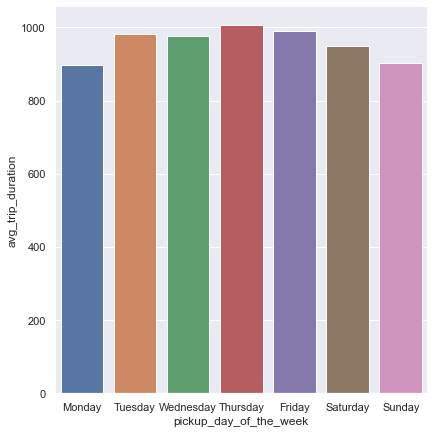

In [397]:
sns.catplot(x = 'pickup_day_of_the_week', y = 'avg_trip_duration', data = avg_trip_duration, height = 6, kind = 'bar', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [407]:
avg_trip_duration_hours = data.groupby(['pickup_hour'])['trip_duration'].mean().reset_index()

In [408]:
avg_trip_duration_hours.rename(columns = {'trip_duration': 'avg_trip_duration'}, inplace = True)

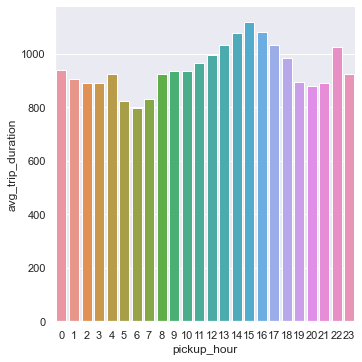

In [409]:
sns.catplot(x = 'pickup_hour', y = 'avg_trip_duration', data = avg_trip_duration_hours, kind = 'bar')

## Обучение на необработанных данных и константные предположения

In [928]:
data = pd.read_csv('train.csv')

Попробуем обучиться на необработанных данных без выделения дополнительных признаков. Предсказывать будем логарифмированную длительность поездки. Чтобы получить  первоначальную длительность необходимо будет сделать обратное преобразование. 

In [929]:
y = data['trip_duration'].apply(lambda x: np.log1p(x))
data.drop(columns = ['trip_duration', 'dropoff_datetime', 'id', 'pickup_datetime'], inplace = True)

In [936]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [932]:
data.dtypes

vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

Выделим численные и категориальные признаки

In [933]:
numeric_features = list(data.select_dtypes(include = ['int64', 'float64']).columns)
categorical_features = list(data.select_dtypes(include = ['object']).columns)

In [934]:
x_train, x_test, y_train, y_test = train_test_split(data, y, train_size = 0.7, random_state = 10)

In [935]:
column_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numeric_features))
column_transformer.fit_transform(x_train)
column_transformer.fit_transform(x_test)

array([[ 1.        ,  0.        ,  0.93018561, ..., -0.60313336,
        -0.41221431, -0.68758014],
       [ 1.        ,  0.        , -1.07505426, ...,  0.84829264,
        -0.68350565, -0.11660056],
       [ 1.        ,  0.        ,  0.93018561, ..., -0.9765934 ,
        -0.8381162 , -0.99443383],
       ...,
       [ 1.        ,  0.        , -1.07505426, ..., -0.51914379,
        -0.39945766, -0.17155149],
       [ 1.        ,  0.        ,  0.93018561, ...,  0.79665284,
        -0.40524067, -0.04815103],
       [ 1.        ,  0.        , -1.07505426, ..., -1.45536988,
         0.02661432, -0.0511271 ]])

In [939]:
for model in [LinearRegression(), Lasso(), Ridge()]:
    pipe = make_pipeline(column_transformer, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(model)
    print('mse = %.4f' %mean_squared_error(y_test, y_pred))
    print('rmse = %.4f' %mean_squared_error(y_test, y_pred, squared = False))
    print('mae = %.4f' %mean_absolute_error(y_test, y_pred))

LinearRegression()
mse = 0.6051
rmse = 0.7779
mae = 0.5892
Lasso()
mse = 0.6309
rmse = 0.7943
mae = 0.6049
Ridge()
mse = 0.6051
rmse = 0.7779
mae = 0.5892


Ниже предсказанием является среднее значение целевой переменной

In [941]:
mean_absolute_error(y_test, np.median(y) * np.ones(y_test.shape))

0.6043231299442116

In [942]:
mean_squared_error(y_test, np.median(y) * np.ones(y_test.shape))

0.6317359246972339

## Обучение на новых признаках

### Функции предобработки и выделения признаков 

Функция возвращает датафрейм без признаков trip_duration, dropoff_datetime, id и логарифмированную целевую переменную

In [946]:
def first_preprocessing(df):
    df = df.copy()
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    y = df['trip_duration'].apply(lambda x: np.log1p(x))
    df.drop(columns = ['trip_duration', 'dropoff_datetime', 'id'], inplace = True)
    
    return df, y

Возвращаяет численные и вещественные признаки

In [947]:
def get_numeric_categorical_features(df):
    numeric_features = list(df.select_dtypes(include = ['int64', 'float64']).columns)
    categorical_features = list(df.select_dtypes(include = ['object']).columns)
    return numeric_features, categorical_features

Возвращает новый датафрейм с логарифмированным расстоянием на сфере

In [948]:
def distance(df):
    df = df.copy()
    lat1 = df['pickup_latitude'].values
    lng1 = df['pickup_longitude'].values
    lat2 = df['dropoff_latitude'].values
    lng2 = df['dropoff_longitude'].values
    
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    df['distance'] = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    df['distance'] = df['distance'].apply(lambda x: np.log1p(x)) 
    df.drop(columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace = True)
    return df

Возвращает датафрейм с признаком - день недели

In [949]:
def day_of_week(df):
    df = df.copy()
    
    tmp = df['pickup_datetime'].dt.date
    df['pickup_day_of_the_week'] = tmp.apply(lambda x: calendar.day_name[x.weekday()])
    
    return df

Возвращает датафрейм с признаком - день месяца

In [950]:
def day_of_month(df):
    df = df.copy()
    
    df['pickup_day'] = data['pickup_datetime'].apply(lambda x: x.day)
    
    return df

Возвращает датафрейм с признаком - чило месяца

In [951]:
def month(df):
    df = df.copy()
    
    df['pickup_month'] = data['pickup_datetime'].apply(lambda x: x.month)
    
    return df

Возвращает датафрейм с признаком -  время суток

In [952]:
def hour_of_day(df):
    df = df.copy()
    
    df['pickup_hour'] = data['pickup_datetime'].apply(lambda x: x.hour)
    
    return df

### Обучение на новых признаках с выбросами

In [953]:
data = pd.read_csv('train.csv')

In [954]:
data,y = first_preprocessing(data)
data = distance(data)
data = day_of_week(data)
data = day_of_month(data)
data = hour_of_day(data)
data = month(data)

In [955]:
data = data.drop(columns = ['pickup_datetime'])

In [956]:
data.head(2)

,vendor_id,passenger_count,store_and_fwd_flag,distance,pickup_day_of_the_week,pickup_day,pickup_hour,pickup_month
0,2,1,N,0.915699,Monday,14,17,3
1,1,1,N,1.031584,Sunday,12,0,6


In [957]:
data.dtypes

vendor_id                   int64
passenger_count             int64
store_and_fwd_flag         object
distance                  float64
pickup_day_of_the_week     object
pickup_day                  int64
pickup_hour                 int64
pickup_month                int64
dtype: object

In [959]:
numeric, categorical = get_numeric_categorical_features(data)

In [960]:
x_train, x_test, y_train, y_test = train_test_split(data, y, train_size = 0.7, random_state = 10)

In [961]:
column_transformer = make_column_transformer((OneHotEncoder(), categorical), (StandardScaler(), numeric))
column_transformer.fit_transform(x_train)
column_transformer.fit_transform(x_test)

array([[ 1.        ,  0.        ,  0.        , ...,  0.86108062,
        -2.12598065, -1.49981269],
       [ 1.        ,  0.        ,  0.        , ..., -0.63215206,
         0.84283208, -0.90475907],
       [ 1.        ,  0.        ,  0.        , ..., -0.40242396,
        -1.18846084,  0.88040179],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -1.55106448,
        -0.71970094,  0.88040179],
       [ 1.        ,  0.        ,  0.        , ..., -1.09160827,
        -0.71970094,  0.28534817],
       [ 1.        ,  0.        ,  0.        , ...,  0.17189631,
         0.37407218, -0.30970545]])

In [962]:
for model in [LinearRegression(), Lasso(), Ridge()]:
    pipe = make_pipeline(column_transformer, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(model)
    print('mse = %.4f' %mean_squared_error(y_test, y_pred))
    print('rmse = %.4f' %mean_squared_error(y_test, y_pred, squared = False))
    print('mae = %.4f' %mean_absolute_error(y_test, y_pred))

LinearRegression()
mse = 0.2689
rmse = 0.5185
mae = 0.3672
Lasso()
mse = 0.6309
rmse = 0.7943
mae = 0.6049
Ridge()
mse = 0.2689
rmse = 0.5185
mae = 0.3672


Результат на моделях линейной регрессии и модели с l2 регуляризацией значительно улучшился по сравнению с обучением на сырых данных. l1 регуляризация по прежнему имеет плохие показатели, скорее всего слишком много важных признаков зануляется из-за чего модель теряет в качестве.

### Удаление выбросов

In [971]:
data = pd.read_csv('train.csv')

In [972]:
data.shape

(1458644, 11)

Удаляем слишком длительные поездки

In [973]:
data = data.drop(data[data['trip_duration'] > 20000].index)

In [974]:
data.shape

(1456576, 11)

Удаляем записи дни, когда был режим ЧС

In [975]:
data['date'] = pd.to_datetime(data['pickup_datetime']).dt.date
data = data.drop(data[data['date'] == pd.to_datetime('2016-01-23')].index)
data = data.drop(data[data['date'] == pd.to_datetime('2016-01-24')].index)
data = data.drop(columns = ['date'])

In [976]:
data.shape

(1451556, 11)

Удаляем поездки с невозможным соотношением расстояния и длительности поездки

In [978]:
data['distance_haversine'] = haversine_array(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)
data['log_distance_haversine'] = data['distance_haversine'].apply(lambda x: np.log1p(x))
data = data.drop(columns = ['distance_haversine'])

In [979]:
data['log_trip_duration'] = data['trip_duration'].apply(lambda x: np.log1p(x))

In [980]:
data = data.drop(data[(data['log_trip_duration'] < 7.5) & (data['log_distance_haversine']>5)].index)

In [981]:
data = data.drop(columns = ['log_trip_duration', 'log_distance_haversine'])

In [982]:
data.shape

(1451547, 11)

### Обучение на данных без выбросов и с новыми признаками

In [983]:
data,y = first_preprocessing(data)
data = distance(data)
data = day_of_week(data)
data = day_of_month(data)
data = hour_of_day(data)
data = month(data)

In [984]:
data = data.drop(columns = ['pickup_datetime'])

In [985]:
data.head(2)

,vendor_id,passenger_count,store_and_fwd_flag,distance,pickup_day_of_the_week,pickup_day,pickup_hour,pickup_month
0,2,1,N,0.915699,Monday,14,17,3
1,1,1,N,1.031584,Sunday,12,0,6


In [986]:
numeric, categorical = get_numeric_categorical_features(data)
x_train, x_test, y_train, y_test = train_test_split(data, y, train_size = 0.7, random_state = 10)
column_transformer = make_column_transformer((OneHotEncoder(), categorical), (StandardScaler(), numeric))
column_transformer.fit_transform(x_train)
column_transformer.fit_transform(x_test)

array([[ 1.        ,  0.        ,  0.        , ...,  0.63428989,
         0.99906202,  0.87843513],
       [ 1.        ,  0.        ,  0.        , ..., -1.54927932,
         0.53027753,  1.47467211],
       [ 1.        ,  0.        ,  1.        , ...,  0.51936519,
        -0.40729146,  0.87843513],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.05525828,
         0.06149303,  1.47467211],
       [ 1.        ,  0.        ,  0.        , ...,  0.51936519,
         0.68653903,  0.28219816],
       [ 1.        ,  0.        ,  0.        , ..., -0.74480645,
        -1.50112195, -1.50651276]])

In [987]:
for model in [LinearRegression(), Lasso(), Ridge()]:
    pipe = make_pipeline(column_transformer, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(model)
    print('mse = %.4f' %mean_squared_error(y_test, y_pred))
    print('rmse = %.4f' %mean_squared_error(y_test, y_pred, squared = False))
    print('mae = %.4f' %mean_absolute_error(y_test, y_pred))

LinearRegression()
mse = 0.2358
rmse = 0.4856
mae = 0.3604
Lasso()
mse = 0.5986
rmse = 0.7737
mae = 0.5990
Ridge()
mse = 0.2358
rmse = 0.4856
mae = 0.3604


Получилось еще уменьшить ошибку в модели линейной регрессии и модели с l2 регуляризацией. Ожидаемо l1 регуляризация показывает плохой результат. Заметим, что LinearRegression и Ridge ведут себя одинаково

### Подбор гиперпараметров

In [988]:
from sklearn.pipeline import Pipeline

In [989]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), categorical), ('ss', StandardScaler(), numeric)], remainder = 'passthrough')
ct.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['store_and_fwd_flag',
                                  'pickup_day_of_the_week']),
                                ('ss', StandardScaler(),
                                 ['vendor_id', 'passenger_count', 'distance',
                                  'pickup_day', 'pickup_hour',
                                  'pickup_month'])])

In [993]:
pipe = Pipeline([('ct', ct), ('model', Ridge())])

In [994]:
alphas = np.logspace(-2,4, 20)
params = {
    'model__alpha' : alphas
}

In [996]:
gs = GridSearchCV(pipe, params, cv = 5, scoring = 'neg_mean_squared_error')
gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['store_and_fwd_flag',
                                                                          'pickup_day_of_the_week']),
                                                                        ('ss',
                                                                         StandardScaler(),
                                                                         ['vendor_id',
                                                                          'passenger_count',
                                                                          'distance',
                                                

Best alpha 61.5848
Best score 0.2385


Text(0, 0.5, 'CV score')

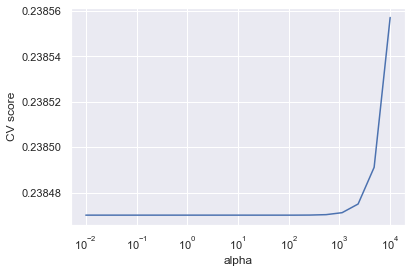

In [998]:
best_alpha = gs.best_params_['model__alpha']
best_score = gs.best_score_
print("Best alpha %.4f" %best_alpha)
print("Best score %.4f" % -best_score)

plt.plot(alphas, -gs.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [999]:
y_pred = gs.predict(x_test)

In [1000]:
mean_squared_error(y_test, y_pred)

0.23577276698369914

In [1001]:
mean_absolute_error(y_test, y_pred)

0.3603968249230237

In [1002]:
mean_squared_error(y_test, y_pred, squared = False)

0.48556437985472034

### Random Forest

Метод Random Forest показывает наилуччший результат

In [1009]:
from sklearn.ensemble import RandomForestRegressor

In [1010]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), categorical), ('ss', StandardScaler(), numeric)])
pipe = Pipeline([('ct', ct),('model', RandomForestRegressor(n_estimators = 10))]) 

In [1011]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['store_and_fwd_flag',
                                                   'pickup_day_of_the_week']),
                                                 ('ss', StandardScaler(),
                                                  ['vendor_id',
                                                   'passenger_count',
                                                   'distance', 'pickup_day',
                                                   'pickup_hour',
                                                   'pickup_month'])])),
                ('model', RandomForestRegressor(n_estimators=10))])

In [1012]:
y_pred = pipe.predict(x_test)

In [1013]:
mean_squared_error(y_test, y_pred)

0.2118980656728713

In [1014]:
mean_squared_error(y_test, y_pred, squared = False)

0.4603238704139416

In [1015]:
mean_absolute_error(y_test, y_pred)

0.33588972126125344